<a href="https://colab.research.google.com/github/sujitojha1/ERA1/blob/main/Session11/ERA1_S11_CIFAR10_Resnet18_GradCam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Models & Modules

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
# Future print function
from __future__ import print_function

# Load modules/models from EVA course
!git clone https://github.com/sujitojha1/pytorch-era1 -q --quiet
!mv pytorch-era1/* .
!rm -rf pytorch-era1
print("Loaded Modules and Models")

# Installing latest Albumentation library
!pip install -U git+https://github.com/albu/albumentations -q --quiet
!pip install torch-lr-finder -q --quiet
!pip install grad-cam

# For inline matplotlib plotting
%matplotlib inline

mv: cannot move 'pytorch-era1/models' to './models': Directory not empty
Loaded Modules and Models
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 17.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.8-py3-none-any.whl size=38247 sha256=68f95c3fca785dda85e11546eca8b61e3af735b8f5984ec316e969caad7af463
  Stored in directory: /root/.cache/pip/wheels/f8/04/36/94ff3c8a4215826a21946b34c01180817e606989fdf53f7cd6
Successfully built grad-cam


# Loading train and test data with transforms and loader functions

In [6]:
from utils import *

# Loading test and train data & dataloader
cifar10 = dataset_cifar10(batch_size=512)

# Train dataloader
trainloader = cifar10.loader(train_flag=True)

# Test dataloader
testloader = cifar10.loader(train_flag=False)

classes = cifar10.classes

CUDA availability ? True
Files already downloaded and verified
Files already downloaded and verified


# Exploratory Data Analysis

## Summary Statistics

In [7]:
cifar10.data_summary_stats()

Files already downloaded and verified
Files already downloaded and verified
(60000, 32, 32, 3)
[0.49186878 0.48265391 0.44717728]
[0.24697121 0.24338894 0.26159259]


## Plotting sample images

Files already downloaded and verified


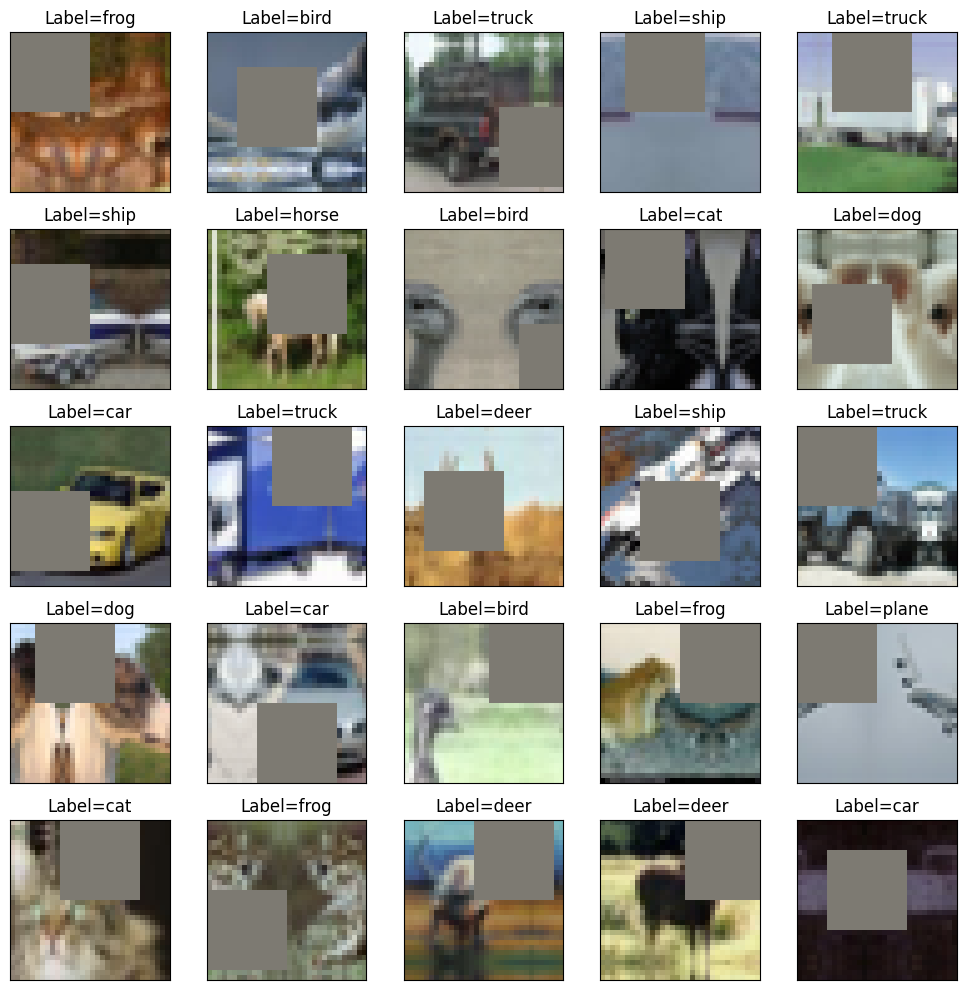

In [8]:
cifar10.sample_pictures(train_flag=True)

## Model

In [17]:
from models.resnet import *

# Loading Custom Model
net = ResNet18()

# Using cuda if available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

# Sending network to device
net = net.to(device)

cuda


## Model Summary

In [18]:
!pip install torchsummary
from torchsummary import summary

# Model Summary
summary(net, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

## LR Finder

  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.07E-02


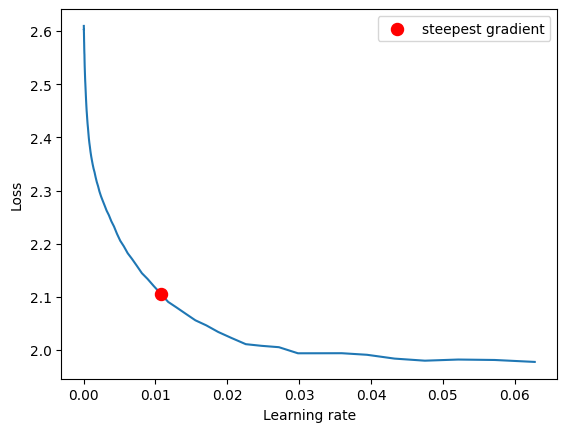

In [19]:
#https://github.com/davidtvs/pytorch-lr-finder

import copy
import torch
from torch_lr_finder import LRFinder
import torch.nn as nn
import torch.optim as optim
import numpy as np

net_exp = copy.deepcopy(net)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_exp.parameters(), lr=1e-5, momentum=0.85)
lr_finder = LRFinder(net_exp, optimizer, criterion, device="cuda")
lr_finder.range_test(trainloader, start_lr=1e-5, end_lr=10, num_iter=200, step_mode="exp")
lr_finder.plot(log_lr=False)
lr_finder.reset()

## Define a Loss function and optimizer

In [20]:
import torch.optim as optim
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.85)
#scheduler = StepLR(optimizer, step_size=6, gamma=0.2)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(trainloader),
                                                epochs=20,pct_start=0.2,
                                                anneal_strategy='linear')

## Training & Testing

In [21]:
# Load train and test model
from main import *

train = train()
test = test()

EPOCHS= 24

for epoch in range(EPOCHS):  # loop over the dataset multiple times
  #train.execute(net, device, batch, optimizer, criterion, epoch)
  train.execute(net, device, trainloader, optimizer, scheduler, criterion, epoch)
  test.execute(net, device, testloader, criterion)

print('Finished Training')

Epoch: 0,Loss=1.67 Batch_id=97 Accuracy=26.77: 100%|██████████| 98/98 [00:43<00:00,  2.25it/s]


Test set: Average loss: 0.0032, Accuracy: 3999/10000 (39.99%)



Epoch: 1,Loss=1.34 Batch_id=97 Accuracy=43.22: 100%|██████████| 98/98 [00:46<00:00,  2.12it/s]


Test set: Average loss: 0.0029, Accuracy: 4710/10000 (47.10%)



Epoch: 2,Loss=1.23 Batch_id=97 Accuracy=50.82: 100%|██████████| 98/98 [00:43<00:00,  2.24it/s]


Test set: Average loss: 0.0029, Accuracy: 5185/10000 (51.85%)



Epoch: 3,Loss=1.19 Batch_id=97 Accuracy=55.92: 100%|██████████| 98/98 [00:44<00:00,  2.19it/s]


Test set: Average loss: 0.0021, Accuracy: 6182/10000 (61.82%)



Epoch: 4,Loss=1.22 Batch_id=97 Accuracy=60.09: 100%|██████████| 98/98 [00:43<00:00,  2.24it/s]


Test set: Average loss: 0.0024, Accuracy: 6052/10000 (60.52%)



Epoch: 5,Loss=0.91 Batch_id=97 Accuracy=62.28: 100%|██████████| 98/98 [00:43<00:00,  2.23it/s]


Test set: Average loss: 0.0018, Accuracy: 6833/10000 (68.33%)



Epoch: 6,Loss=0.96 Batch_id=97 Accuracy=64.92: 100%|██████████| 98/98 [00:43<00:00,  2.25it/s]


Test set: Average loss: 0.0018, Accuracy: 6861/10000 (68.61%)



Epoch: 7,Loss=0.93 Batch_id=97 Accuracy=67.39: 100%|██████████| 98/98 [00:44<00:00,  2.21it/s]


Test set: Average loss: 0.0018, Accuracy: 6897/10000 (68.97%)



Epoch: 8,Loss=0.80 Batch_id=97 Accuracy=69.23: 100%|██████████| 98/98 [00:43<00:00,  2.24it/s]


Test set: Average loss: 0.0017, Accuracy: 7155/10000 (71.55%)



Epoch: 9,Loss=0.75 Batch_id=97 Accuracy=71.07: 100%|██████████| 98/98 [00:47<00:00,  2.08it/s]


Test set: Average loss: 0.0016, Accuracy: 7323/10000 (73.23%)



Epoch: 10,Loss=0.73 Batch_id=97 Accuracy=71.76: 100%|██████████| 98/98 [00:44<00:00,  2.22it/s]


Test set: Average loss: 0.0015, Accuracy: 7443/10000 (74.43%)



Epoch: 11,Loss=0.67 Batch_id=97 Accuracy=73.72: 100%|██████████| 98/98 [00:44<00:00,  2.18it/s]


Test set: Average loss: 0.0014, Accuracy: 7641/10000 (76.41%)



Epoch: 12,Loss=0.68 Batch_id=97 Accuracy=74.29: 100%|██████████| 98/98 [00:44<00:00,  2.20it/s]


Test set: Average loss: 0.0015, Accuracy: 7570/10000 (75.70%)



Epoch: 13,Loss=0.73 Batch_id=97 Accuracy=75.48: 100%|██████████| 98/98 [00:43<00:00,  2.25it/s]


Test set: Average loss: 0.0012, Accuracy: 7866/10000 (78.66%)



Epoch: 14,Loss=0.62 Batch_id=97 Accuracy=76.39: 100%|██████████| 98/98 [00:44<00:00,  2.22it/s]


Test set: Average loss: 0.0013, Accuracy: 7923/10000 (79.23%)



Epoch: 15,Loss=0.58 Batch_id=97 Accuracy=77.25: 100%|██████████| 98/98 [00:43<00:00,  2.24it/s]


Test set: Average loss: 0.0011, Accuracy: 8149/10000 (81.49%)



Epoch: 16,Loss=0.65 Batch_id=97 Accuracy=78.49: 100%|██████████| 98/98 [00:44<00:00,  2.21it/s]


Test set: Average loss: 0.0010, Accuracy: 8300/10000 (83.00%)



Epoch: 17,Loss=0.57 Batch_id=97 Accuracy=78.99: 100%|██████████| 98/98 [00:43<00:00,  2.24it/s]


Test set: Average loss: 0.0009, Accuracy: 8452/10000 (84.52%)



Epoch: 18,Loss=0.51 Batch_id=97 Accuracy=79.95: 100%|██████████| 98/98 [00:44<00:00,  2.20it/s]


Test set: Average loss: 0.0009, Accuracy: 8520/10000 (85.20%)



Epoch: 19,Loss=0.56 Batch_id=97 Accuracy=80.63: 100%|██████████| 98/98 [00:43<00:00,  2.24it/s]


Test set: Average loss: 0.0008, Accuracy: 8582/10000 (85.82%)



  0%|          | 0/98 [00:01<?, ?it/s]


ValueError: ignored

## Display an image from the test set

Files already downloaded and verified


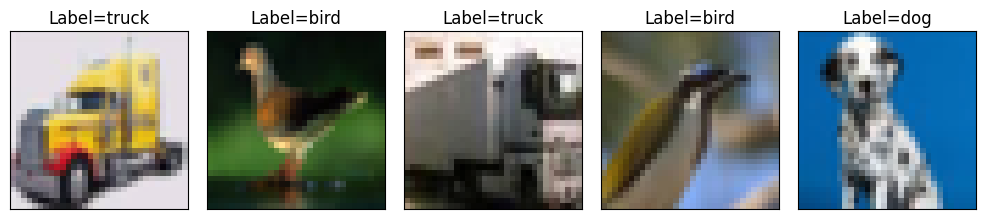

In [44]:
images, labels = cifar10.sample_pictures(train_flag=False, return_flag = True)

## Prediction of sampe test set

In [47]:
images,labels = images.to(device),labels.to(device)
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(5)))

Predicted:  truck  bird truck  bird   dog


In [48]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50

model = net
target_layers = [model.layer4[-1]]
input_tensor = images[3].unsqueeze(dim=0)# Create an input tensor image for your model..
# Note: input_tensor can be a batch tensor with several images!

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers)

# You can also use it within a with statement, to make sure it is freed,
# In case you need to re-create it inside an outer loop:
# with GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda) as cam:
#   ...

# We have to specify the target we want to generate
# the Class Activation Maps for.
# If targets is None, the highest scoring category
# will be used for every image in the batch.
# Here we use ClassifierOutputTarget, but you can define your own custom targets
# That are, for example, combinations of categories, or specific outputs in a non standard model.

targets = [ClassifierOutputTarget(2)]

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(input_tensor, grayscale_cam, use_rgb=True)

TypeError: ignored

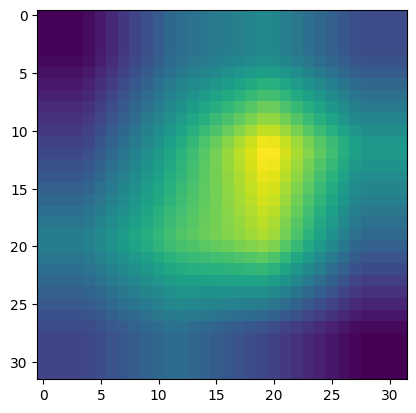

In [49]:
import matplotlib.pyplot as plt
plt.imshow(grayscale_cam)

In [37]:
labels

tensor([5, 1, 9, 4, 9], device='cuda:0')

In [33]:
list(classes)

['plane',
 'car',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [28]:
images[0].shape

torch.Size([3, 32, 32])

## Evaluating Training Accuracy

In [ ]:
from evaluate import *
calAccuracy(net, trainloader, device)

## Evaluating Test Accuracy

In [ ]:
calAccuracy(net, testloader, device)

## Evaluating test Accuracy over different classes

In [ ]:
calClassAccuracy(net, testloader,classes, device)

## Misclassified Images

In [ ]:
from utils import plot_misclassified_images
plot_misclassified_images(net, testloader, classes, device)